### Домашнее задание 5. Оганян Роберт

#### Постановка задачи

1. Определить тип данных для каждого столбца.

2. Построить диаграммы рассеивания для пар данных:
GRE – Chance of Admit, TOEFL – Chance of Admit,
University Rating – Chance of Admit, SOP – Chance of Admit,
LOR – Chance of Admit, CGPA – Chance of Admit.
Привести визуальную оценку зависимости шанса поступления от
указанных величин.

3. Построить модель регрессии (простой линейной /
множественной линейной / полиномиальной по независимым
переменным), которая даст наилучший прогноз шанса поступления
абитуриента. В качестве независимых переменных может
выбираться любое количество величин из пункта 2.
Выбрать оптимальную и обосновать оптимальность
построенной модели с помощью разобранных метрик (R2, MSE, RSS)

### 1. Определить тип данных для каждого столбца.

In [203]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [204]:
data = pd.read_excel("data/enrollment.xlsx")
data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


In [205]:
data['SOP'].value_counts()

4.0    70
3.5    70
3.0    64
4.5    53
2.5    47
5.0    37
2.0    33
1.5    20
1.0     6
Name: SOP, dtype: int64

In [206]:
data['LOR '].value_counts()

3.0    85
4.0    77
3.5    73
4.5    45
2.5    39
2.0    38
5.0    35
1.5     7
1.0     1
Name: LOR , dtype: int64

На первый взгляд SOP и LOR казались непрерывными, но мы видим, что они принимают 9 различных значений, значит относятся к количественным дискретным.

In [207]:
data.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

In [208]:
data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

**Количественные дискретные** - целые числа/счетное множество:*SOP*, *LOR*, *Serial No*, *GRE Score*, *TOEFL Score*

**Количественные непрерывные** - вещественные числа и дата / Несчетное множество: *CGPA*, *Chance of Admit*

**Категориальные ординальные - категориальные признаки, которые "упорядочиваются", но порядок выражается не числами**: *University Rating*

**Категориальные номинальные дихотомические (бинарные) - категориальный признак, который может быть либо true, либо false**: *Research*

**Категориальные номинальные** - нечисловые данные, можно сказать классы: Нет

### 2. Построить диаграммы рассеивания для пар данных: GRE , TOEFL , University Rating, SOP, LOR , CGPA с Chance of Admit. Привести визуальную оценку зависимости шанса поступления от указанных величин.

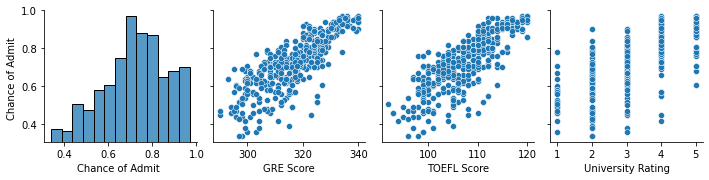

In [209]:
data2 = data[["Chance of Admit ", "GRE Score", "TOEFL Score", "University Rating"]].astype(float).dropna()
sns.pairplot(data2, y_vars=["Chance of Admit "], kind="scatter")

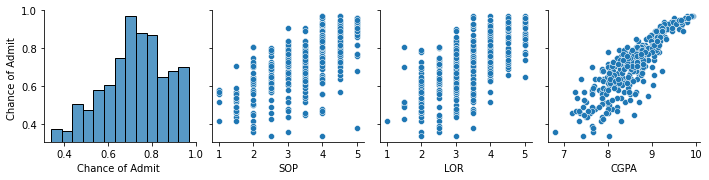

In [210]:
data3 = data[["Chance of Admit ", "SOP", "LOR ", "CGPA"]].astype(float).dropna()
sns.pairplot(data3, y_vars=["Chance of Admit "], kind="scatter")

Построим также матрицу ковариации

In [211]:
data_all = data.dropna().drop('Serial No.', axis = 1)

<AxesSubplot:>

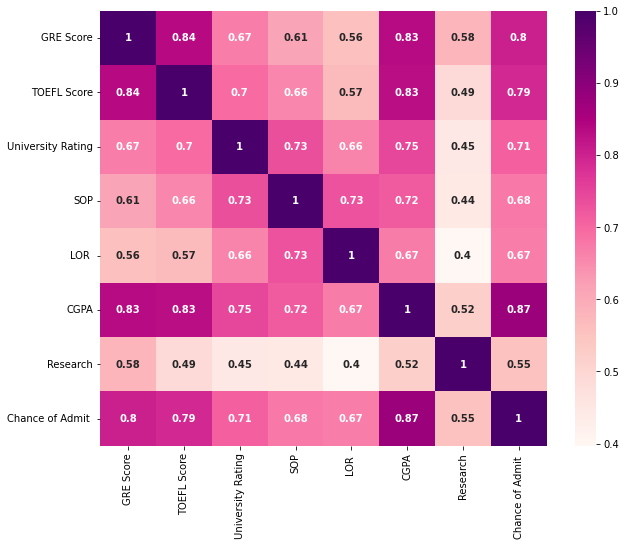

In [212]:
corr_fi = data_all.corr()
fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr_fi,
            xticklabels = corr_fi.columns,
            yticklabels = corr_fi.columns,
            annot = True,
            cmap="RdPu",
            annot_kws={"weight":"bold"})

Выводы:

1. Очевидна явная линейная зависимость между Change of Admit и GRE Score, TOEFK Score и GGPA.
2. Чем больше SOP, LOR, University rating, тем в среднем Chance of Admit выше.
3. Матрица ковариации подтверждает мои тезисы.

### 3. Построить модель регрессии (простой линейной / множественной линейной / полиномиальной по независимым переменным), которая даст наилучший прогноз шанса поступления абитуриента. В качестве независимых переменных может выбираться любое количество величин из пункта 2. Выбрать оптимальную и обосновать оптимальность построенной модели с помощью разобранных метрик (R2, MSE, RSS)

In [213]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [214]:
def residual_sum_of_squares(val_y, y_pred):
    return ((val_y - y_pred)**2).sum()    

Подготовим данные

In [215]:
X = data_all.drop('Chance of Admit ', axis = 1)
y = data_all['Chance of Admit ']

In [216]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0)

In [217]:
metrics = ['r2', 'mse', 'rss']

#### Простая линейная (с одним признаком) регрессия

In [218]:
cols = data.columns.tolist()[1:-1]
results1 = [[], [], []]

for col in cols:
    model = LinearRegression()
    cur_train_x = np.reshape(train_x[col].values, (-1, 1))
    model.fit(cur_train_x, train_y)
    cur_val_x = np.reshape(val_x[col].values, (-1, 1))
    y_pred = model.predict(cur_val_x)
    
    results1[0].append(r2_score(val_y, y_pred))
    results1[1].append(mean_squared_error(val_y, y_pred))
    results1[2].append(residual_sum_of_squares(val_y, y_pred))       

    
results1 = np.concatenate((np.array(cols).T.reshape(len(cols),1), np.array(results1).T), axis=1)    
results1 = sorted(results1, key=lambda x:x[2])

for i in range(len(results1)):
    for j in range(len(results1[0])):
        if (j == 0):
            print (' {:4}'.format(results1[i][j]))
        else:
            print (metrics[j-1] + ' {:4}'.format(results1[i][j]))
    print()

 CGPA
r2 0.6730821148420707
mse 0.005939275570514724
rss 0.4751420456411779

 TOEFL Score
r2 0.6217126483450097
mse 0.006872529550452167
rss 0.5498023640361733

 GRE Score
r2 0.5456668070172048
mse 0.008254091184558793
rss 0.6603272947647034

 SOP 
r2 0.4382835132002727
mse 0.01020497549711394
rss 0.8163980397691152

 LOR 
r2 0.3910151898510317
mse 0.011063722022993723
rss 0.8850977618394978

 University Rating
r2 0.36779434536396804
mse 0.011485586352386758
rss 0.9188469081909406

 Research
r2 0.2354141655101606
mse 0.013890601201440495
rss 1.1112480961152396



Из простых моделей с одним признаком лучшей оказалась модель с признаком CGPA.
1. r2 = 0.6730821148420707

2. mse = 0.005939275570514724

3. rss = 0.4751420456411779

#### Множественная линейная (обычная) регрессия

In [223]:
from itertools import combinations

results2 = [[], [], []]
metrics2 = []
for cnt in range(1, len(cols)):
    combs = list(combinations(cols, cnt))
    for col in combs:
        metrics2.append(','.join(col))
        col = list(col)
        model = LinearRegression()
        cur_train_x = np.reshape(train_x[col].values, (-1, len(col)))
        model.fit(cur_train_x, train_y)
        cur_val_x = np.reshape(val_x[col].values, (-1, len(col)))
        y_pred = model.predict(cur_val_x)

        results2[0].append(r2_score(val_y, y_pred))
        results2[1].append(mean_squared_error(val_y, y_pred))
        results2[2].append(residual_sum_of_squares(val_y, y_pred))       

    
results2 = np.concatenate((np.array(metrics2).T.reshape(len(metrics2),1), np.array(results2).T), axis=1)    
results2 = sorted(results2, key=lambda x:x[2])
results2 = results2[:10]

for i in range(len(results2)):
    for j in range(len(results2[0])):
        if (j == 0):
            print (' {:4}'.format(results2[i][j]))
        else:
            print (metrics[j-1] + ' {:4}'.format(results2[i][j]))
    print()

 TOEFL Score,LOR ,CGPA,Research
r2 0.7409169815906385
mse 0.004706886688779915
rss 0.3765509351023932

 TOEFL Score,University Rating,LOR ,CGPA,Research
r2 0.7403901131205717
mse 0.004716458563477531
rss 0.3773166850782025

 TOEFL Score,SOP,LOR ,CGPA,Research
r2 0.7396065872329732
mse 0.004730693257797884
rss 0.37845546062383073

 TOEFL Score,University Rating,SOP,LOR ,CGPA,Research
r2 0.7386069268081306
mse 0.004748854572946519
rss 0.3799083658357215

 GRE Score,TOEFL Score,University Rating,LOR ,CGPA,Research
r2 0.7360575747319804
mse 0.0047951698869563505
rss 0.38361359095650804

 GRE Score,TOEFL Score,LOR ,CGPA,Research
r2 0.7359165973516898
mse 0.004797731091310009
rss 0.3838184873048008

 GRE Score,TOEFL Score,SOP,LOR ,CGPA,Research
r2 0.7354852893643801
mse 0.004805566872430272
rss 0.38444534979442174

 TOEFL Score,LOR ,CGPA
r2 0.7316636091573834
mse 0.0048749971878771295
rss 0.38999977503017036

 TOEFL Score,University Rating,LOR ,CGPA
r2 0.7314883925451968
mse 0.00487818043294

Для множественной регрессии оказалась лучшей модель с признаками TOEFL Score,LOR ,CGPA,Research.

1. r2 = 0.7409169815906385

2. mse = 0.004706886688779915

3. rss = 0.3765509351023932

#### Полиномиальная (признаки в степени) регрессия

In [220]:
from sklearn.preprocessing import PolynomialFeatures
def polynomiс_regression(data_train, data_val, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_train_x = poly.fit_transform(data_train)
    model = LinearRegression()
    model.fit(poly_train_x, train_y)
    y_pred = model.predict(poly.fit_transform(data_val))
    return y_pred

In [224]:
results3 = [[], [], []]
metrics3 = []
for cnt in range(1, len(cols)):
    combs = list(combinations(cols, cnt))
    for col in combs:
        for degree in range(2,4):
            metrics3.append('degree ' + str(degree) + '.' + ','.join(col))
            col = list(col)
            model = LinearRegression()
            cur_train_x = np.reshape(train_x[col].values, (-1, len(col)))
            model.fit(cur_train_x, train_y)
            cur_val_x = np.reshape(val_x[col].values, (-1, len(col)))
            y_pred = polynomiс_regression(cur_train_x, cur_val_x, degree)

            results3[0].append(r2_score(val_y, y_pred))
            results3[1].append(mean_squared_error(val_y, y_pred))
            results3[2].append(residual_sum_of_squares(val_y, y_pred))       
        

    
results3 = np.concatenate((np.array(metrics3).T.reshape(len(metrics3),1), np.array(results3).T), axis=1)    
results3 = sorted(results3, key=lambda x:x[2])
results3 = results3[:10]

for i in range(len(results3)):
    for j in range(len(results3[0])):
        if (j == 0):
            print (' {:4}'.format(results3[i][j]))
        else:
            print (metrics[j-1] + ' {:4}'.format(results3[i][j]))
    print()

 degree 2.TOEFL Score,SOP,LOR ,CGPA,Research
r2 0.7313519247313405
mse 0.004880659709817196
rss 0.3904527767853757

 degree 2.TOEFL Score,LOR ,CGPA,Research
r2 0.7258822259459669
mse 0.004980030377036428
rss 0.39840243016291427

 degree 2.TOEFL Score,University Rating,SOP,LOR ,CGPA,Research
r2 0.722955763482911
mse 0.005033196838108019
rss 0.4026557470486415

 degree 2.TOEFL Score,SOP,CGPA,Research
r2 0.7219010248232811
mse 0.005052358786226554
rss 0.4041887028981243

 degree 2.TOEFL Score,SOP,LOR ,CGPA
r2 0.7204252303869796
mse 0.0050791702585887746
rss 0.406333620687102

 degree 2.TOEFL Score,LOR ,CGPA
r2 0.720004058217265
mse 0.005086821897401248
rss 0.40694575179209985

 degree 2.GRE Score,SOP,LOR ,CGPA,Research
r2 0.7197051176541084
mse 0.00509225289541145
rss 0.407380231632916

 degree 2.TOEFL Score,CGPA,Research
r2 0.718488638112941
mse 0.005114353268468116
rss 0.4091482614774493

 degree 2.GRE Score,University Rating,SOP,LOR ,CGPA,Research
r2 0.7175137645104586
mse 0.0051320642

Из полиномиальных моделей оказалась модель со степенью 2 и признаками TOEFL Score,SOP,LOR ,CGPA,Research.

1. r2 = 0.7313519247313405

2. mse = 0.004880659709817196

3. rss = 0.3904527767853757

#### Выводы

1. Лучше оказалась полиномиальная модель со степенью 2 и признаками TOEFL Score, SOP, LOR, CGPA, Research.
2. Это не стало неожиданностью, так как прямая линия очень редко когда является идеальной моделью. Как правило, зависимости всегда нелинейны, для чего и пригодилась полиномиальная регрессия
3. Все полученные наблюдения и все сделанные выводы в действительности могут быть полностью неверными, так как мы обучались на 400 данных. Это очень маленькая выборка.